In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import os
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import time
stocks = {}

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies

In [35]:
def graph(data, name, short=False):
    f1, ax = plt.subplots(figsize = (18,10))
    
    shortChange = 0
    if short:
        shortChange = -20
    else:
        ax.plot(data['day'], data['SMA05'], color='black')
        ax.plot(data['day'], data['SMA20'], color='blue')
        ax.plot(data['day'], data['SMA50'], color='purple')
        ax.legend()
    
    rawData = data.iloc[shortChange:, [5, 0, 1, 2, 3]].copy()
    
    candlestick_ohlc(ax, rawData.values, width=.6, colorup='green', colordown='red')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    plt.show()

def get_data(symbols):
    ts = TimeSeries(key='PBEK7SZPONK01WUK', output_format='pandas')
    loopIndex = 0
    for s in symbols:
        # API asks for only 5 requests a minute, that is what this is for
        if (loopIndex % 5 == 0) and (loopIndex != 0):
            time.sleep(60)
            
        try:
            data, _ = ts.get_daily(symbol=s)

            data.rename(index=str, columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', 
                                            '4. close': 'close', '5. volume': 'volume'}, inplace=True)

            data['day'] = mdates.date2num(pd.to_datetime(data.index))

            data['SMA05'] = data['close'].rolling(5).mean()
            data['SMA20'] = data['close'].rolling(20).mean()
            data['SMA50'] = data['close'].rolling(50).mean()

            stocks[s] = data
            loopIndex += 1
        except:
            pass

def check_patterns(data):
    bullish = []
    bearish = []
    
    # at beginning define lengths and such to use for calculations later ---
        
    # get percent change over past 5 days
    change = (data.iloc[99, 3] - data.iloc[85, 3]) / data.iloc[99, 3]
    
    # get median of candle lengths to define small and large candles
    sizes = []
    for _, row in data.iterrows():
        sizes.append(abs(row['open']-row['close']))
    median = np.percentile(sizes, 50)
    
    # these are the most recent candles, the important ones we will analyze
    one = data.iloc[96]
    two = data.iloc[97]
    three = data.iloc[98]
    four = data.iloc[99]
    
    # this grabs more data about the candlesticks
    def candle_detail(c):
        color, size, uw, dw = None, None, None, None
        l = c['open'] - c['close']
        if l == 0:
            color = 'doji'
        elif l > 0:
            color = 'red'
        else:
            color = 'green'
        l = abs(l)
        if l > median:
            size = 'long'
        else:
            size = 'short'
        if color == 'red' or color == 'doji':
            uw = c['high'] - c['open']
            dw = c['close'] - c['low']
        else:
            uw = c['high'] - c['close']
            dw = c['open'] - c['low']
        return l, color, uw, dw, size
    
    # run function on important candles
    len1, color1, uwick1, dwick1, size1 = candle_detail(one)
    len2, color2, uwick2, dwick2, size2 = candle_detail(two)
    len3, color3, uwick3, dwick3, size3 = candle_detail(three)
    len4, color4, uwick4, dwick4, size4 = candle_detail(four)
    
    # used to determine if there was up or down trend before checking for patterns
    def trend_find(day):
        if (data.iloc[day, 3] - data.iloc[day-4, 3]) > 0:
            return 'up'
        else:
            return 'down'
    trend = None
    
    # Bullish Single Candle Patterns ---
    trend = trend_find(97)
    
    # Bullish Hammer
    if trend == 'down':
        if dwick3 >= (2 * len3) and uwick3 <= (0.15 * len3):
            if color3 == 'green':
                bullish.append('Green Bullish Hammer')
            else:
                bullish.append('Red Bullish Hammer')
            
    # Inverted Hammer
    if trend == 'down':
        if uwick3 >= (2 * len3) and dwick3 <= (0.15 * len3):
            if color3 == 'green':
                bullish.append('Green Inverted Hammer')
            else:
                bullish.append('Red Inverted Hammer')
            
    # Belt Hold
    if trend == 'down':
        if color3 == 'green':
            if size3 == 'long':
                if dwick3 <= (0.05 * len3) and uwick3 <= (0.05 * len3):
                    bullish.append('Belt Hold')
                
    # Bullish Two Candle Patterns ---
    trend = trend_find(96)
    
    # Harami
    if trend == 'down':
        if color2 == 'red' and color3 == 'green':
            if size2 == 'long' and size3 == 'short':
                if three['high'] < two['open'] and three['low'] > two['close']:
                    bullish.append('Harami')
                
    # Harami Cross
    if trend == 'down':
        if color2 == 'red' and color3 == 'doji':
            if size2 == 'long':
                if three['high'] < two['open'] and three['low'] > two['close']:
                    bullish.append('Harami Cross')
                
    # Homing Pigeon
    if trend == 'down':
        if color2 == 'red' and color3 == 'red':
            if size2 == 'long':
                if three['high'] < two['high'] and three['low'] > two['low']:
                    if three['open'] < two['open'] and three['close'] > two['close']:
                        bullish.append('Homing Pigeon')
                
    # Matching Low
    if trend == 'down':
        if color2 == 'red':
            if size2 == 'red':
                if three['low'] == two['low']:
                    bullish.append('Matching Low')
                
    # Piercing Line
    if trend == 'down':
        if color2 == 'red' and color3 == 'green':
            if size2 == 'long' and size3 == 'long':
                if uwick2 <= (0.2 * len2) and dwick2 <= (0.2 * len2):
                    if uwick3 <= (0.15 * len3):
                        if three['close'] > ((two['open'] + two['close'])/2) and three['close'] < two['open']:
                            bullish.append('Piercing Line')
                    
    # Meeting Line
    if trend == 'down':
        if color2 == 'red' and color3 == 'green':
            if size2 == 'long' and size3 == 'long':
                if uwick2 <= (0.2 * len2) and dwick2 <= (0.2 * len2):
                    if uwick3 <= (0.15 * len3):
                        if three['close'] == two['close']:
                            bullish.append('Piercing Line')
                        
    # One Green Soldier
    if trend == 'down':
        if color2 == 'red' and color3 == 'green':
            if size2 == 'long' and size3 == 'long':
                if three['open'] > two['close'] and three['close'] > two['open']:
                    bullish.append('One Green Soldier')
                
    # Engulfing
    if trend == 'down':
        if color2 == 'red' and color3 == 'green':
            if size2 == 'long' and size3 == 'long':
                if three['high'] > two['high'] and three['low'] < two['low']:
                    bullish.append('Engulfing')
                
    # Kicking/Kicker
    if trend == 'down':
        if color2 == 'red' and color3 == 'green':
            if size2 == 'long':
                if three['open'] > two['open']:
                    if uwick3 <= (0.15 * len3):
                        bullish.append('Kicking/Kicker')     
                
    # Bullish Three Candle Patterns ---
    trend = trend_find(95)
    
    # Morning Star
    if trend == 'down':
        if color1 == 'red' and color2 == 'green' and color3 == 'green':
            if size1 == 'long':
                if two['open'] < one['close']:
                    if three['close'] < one['open'] and three['close'] > one['close']:
                        bullish.append('Morning Star')
                    
    # Doji Morning Star
    if trend == 'down':
        if color1 == 'red' and color2 == 'doji' and color3 == 'green':
            if size1 == 'long':
                if two['open'] < one['close']:
                    if three['close'] < one['open'] and three['close'] > one['close']:
                        bullish.append('Doji Morning Star')
                    
    # Abandoned Baby
    if trend == 'down':
        if color1 == 'red' and color2 == 'doji' and color3 == 'green':
            if size1 == 'long':
                if two['high'] < one['low']:
                    if three['low'] > two['high']:
                        if three['close'] < one['open'] and three['close'] > one['close']:
                            bullish.append('Abandoned Baby')
                    
    # Two Rabbits
    if trend == 'down':
        if color1 == 'red' and color2 == 'green' and color3 == 'green':
            if size1 == 'long' and size2 == 'small':
                if two['close'] < one['close']:
                    if three['open'] > two['open'] and three['close'] > two['close']:
                        bullish.append('Two Rabbits')
                    
    # Downside Gap Two Rabbits
    if trend == 'down':
        if color1 == 'red' and color2 == 'green' and color3 == 'green':
            if size1 == 'long' and size2 == 'small':
                if two['close'] < one['close']:
                    if three['open'] < two['open'] and three['close'] > two['close']:
                        bullish.append('Downside Gap Two Rabbits')
                        
    # Deliberation Block
    if trend == 'down':
        if color1 == 'red' and color2 == 'red' and color3 == 'red':
            if size3 == 'small':
                if two['open'] > one['close'] and two['open'] < one['open']:
                    if three['open'] < two['close']:
                        bullish.append('Deliberation Block')
                    
    # Decent Block
    if trend == 'down':
        if color1 == 'red' and color2 == 'red' and color3 == 'red':
            if size1 == 'long' and size2 == 'long' and size3 == 'long':
                if len1 > len2 and len2 > len3:
                    bullish.append('Decent Block')
                
    # Three Green Soldiers
    if trend == 'down':
        if color1 == 'green' and color2 == 'green' and color3 == 'green':
            if size1 == 'long' and size2 == 'long' and size3 == 'long':
                if two['high'] > one['high'] and three['high'] > two['high']:
                    if two['open'] > one['low'] and two['open'] < one['high']:
                        if three['open'] > two['low'] and three['open'] < two['high']:
                            bullish.append('Three Green Soldiers')
                            
    # Check for bullish confirmation ---
    if bullish:
        if color4 == 'green':
            bullish.append('Next Day Confirmation')
            
    # return early if we know the stock is bullish
    if bullish:
        return bullish, bearish, change
            
    # Bearish Single Candle Patterns ---
    trend = trend_find(97)
    
    # Hanging Man
    if trend == 'up':
        if size3 == 'small':
            if dwick3 >= (2 * len3) and uwick3 < (0.15 * len3):
                bearish.append('Hanging Man')
    
    # Bearish Belt Hold
    if trend == 'up':
        if color3 == 'red':
            if size3 == 'long':
                if uwick3 <= (0.2 * len3):
                    if three['open'] > two['high']:
                        bearish.append('Bearish Belt Hold')
                        
    # Bearish Two Candle Patterns ---
    trend = trend_find(96)
    
    # Shooting Star
    if trend == 'up':
        if color2 == 'green':
            if size2 == 'long' and size3 == 'small':
                if uwick3 >= (2 * len3):
                    if color3 == 'green':
                        bearish.append('Green Shooting Star')
                    else:
                        bearish.append('Red Shooting Star')
                        
    # Bearish Harami
    if trend == 'up':
        if color2 == 'green' and color3 == 'red':
            if size3 == 'small':
                if abs(three['open'] - three['close']) < abs(two['open'] - two['close']):
                    bearish.append('Bearish Harami')
                    
    # Bearish Harami Cross:
    if trend == 'up':
        if color2 == 'green' and color3 == 'doji':
            if three['high'] < two['high'] and three['low'] > two['low']:
                bearish.append('Bearish Harami Cross')
                
    # Bearish Doji Star
    if trend == 'up':
        if color2 == 'green' and color3 == 'doji':
            if uwick2 <= (0.2 * len2):
                if three['open'] > two['close']:
                    bearish.append('Bearish Doji Star')
                    
    # Matching High
    if trend == 'up':
        if color2 == 'green' and color3 == 'green':
            if size3 == 'small':
                if three['open'] > two['open']:
                    if three['close'] == two['close']:
                        bearish.append('Matching High')
                        
    # Descending Hawk
    if trend == 'up':
        if color2 == 'green' and color3 == 'green':
            if size3 == 'small':
                if three['open'] > two['open'] and three['close'] < two['close']:
                    bearish.append('Descending Hawk')
                    
    # Bearish Meeting Line
    if trend == 'up':
        if color2 == 'green' and color3 == 'red':
            if uwick2 <= (0.2 * len2):
                if three['close'] == two['close']:
                    bearish.append('Bearish Meeting Line')
                    
    # Cloud Cover
    if trend == 'up':
        if color2 == 'green' and color3 == 'red':
            if uwick2 <= (0.2 * len2):
                if three['open'] > two['close']:
                    if three['close'] < ((two['open'] + two['close'])/2):
                        bearish.append('Cloud Cover')
                        
    # One Black Crow
    if trend == 'up':
        if color2 == 'green' and color3 == 'red':
            if uwick2 <= (0.2 * len2):
                if three['open'] > two['open'] and three['open'] < two['high']:
                    if three['close'] < two['open']:
                        bearish.append('One Black Crow')
                        
    # Bearish Kicking
    if trend == 'up':
        if color2 == 'green' and color3 == 'red':
            if uwick2 <= (0.2 * len2):
                if three['open'] < two['open']:
                    if dwick3 <= (0.2 * len3):
                        bearish.append('Bearish Kicking')
                        
    # Bearish Engulfing
    if trend == 'up':
        if color2 == 'green' and color3 == 'red':
            if size3 == 'long':
                if three['open'] > two['close'] and three['close'] < two['open']:
                    bearish.append('Bearish Engulfing')
                    
    # Bearish Three Candle Patterns ---
    trend = trend_find(95)
    
    # Advance Block
    if trend == 'up':
        if color1 == 'green' and color2 == 'green' and color3 == 'green':
            if two['open'] > one['open'] and two['open'] < one['close'] and two['close'] > one['close']:
                if three['open'] > two['open'] and three['open'] < two['close'] and three['close'] > two['close']:
                    if uwick2 >= (0.75 * len2) and uwick3 >= (0.75 * len3):
                        bearish.append('Advance Block')
                        
    # Bearish Deliberation Block
    if trend == 'up':
        if color1 == 'green' and color2 == 'green' and color3 == 'green':
            if size1 == 'long' and size2 == 'long' and size3 == 'short':
                if two['open'] > one['open'] and two['open'] < one['close'] and two['close'] > one['close']:
                    if three['open'] > two['close']:
                        bearish.append('Bearish Deliberation Block')
                
    # Evening Star
    if trend == 'up':
        if color1 == 'green' and color3 == 'red':
            if size2 == 'small':
                if uwick1 <= (0.2 * len1):
                    if two['open'] > one['close']:
                        if three['close'] > one['open'] and three['close'] < one['close']:
                            if dwick3 <= (0.2 * len3):
                                bearish.append('Evening Star')
                                
    # Evening Doji
    if trend == 'up':
        if color1 == 'green' and color2 == 'doji' and color3 == 'red':
            if uwick1 <= (0.2 * len1):
                if two['open'] > one['close']:
                    if three['close'] > one['open'] and three['close'] < one['close']:
                        if dwick3 <= (0.2 * len3):
                            if three['open'] < two['low']:
                                bearish.append('Evening Star')
                                
    # Bearish Abandoned Baby
    if trend == 'up':
        if color1 == 'green' and color3 == 'red':
            if uwick1 <= (0.2 * len1):
                if two['low'] > one['high']:
                    if three['high'] < two['low']:
                        bearish.append('Bearish Abandoned Baby')
                        
    # Two Crows
    if trend == 'up':
        if color1 == 'green' and color2 == 'red' and color3 == 'red':
            if size2 == 'small' and size3 == 'long':
                if uwick1 <= (0.2 * len1):
                    if two['open'] > one['close']:
                        if three['open'] > two['close'] and three['open'] < two['open']:
                            if three['close'] > one['open'] and three['close'] < one['close']:
                                bearish.append('Two Crows')
                                
    # Three Black Crows
    if trend == 'up':
        if color1 == 'red' and color2 == 'red' and color3 == 'red':
            if size1 == 'long' and size2 == 'long' and size3 == 'long':
                if two['low'] < one['low'] and three['low'] < two['low']:
                    if two['open'] > one['close'] and two['open'] < one['open'] and two['close'] < one['close']:
                        if three['open'] > two['close'] and three['open'] < two['open']:
                            bearish.append('Three Black Crows')
                            
    # Check for bearish confirmation ---
    if bearish:
        if color4 == 'red':
            bearish.append('Next Day Confirmation')
    
    return bullish, bearish, change

def bullish_patterns(r):
    for x in r:
        if x[2]:
            print(x[1])
            print(x[2])
            graph(stocks[x[1]], name=x[1], short=True)
            
def bearish_patterns(r):
    for x in r:
        if x[3]:
            print(x[1])
            print(x[3])
            graph(stocks[x[1]], name=x[1], short=True)
            
def trenders(r):
    count = 0
    for x in sorted(r, reverse=True):
        if x[0] > 0:
            print(x[1])
            print("['{0:.2f}% Change']".format(100*x[0]))
            graph(stocks[x[1]], name=x[1], short=True)
            count += 1
        if count > 4:
            break

In [36]:
symbols = ['GRPN',
            'NIO', 'XXII', 'SIRI', 'RAD', 'IQ', 'APHA', 'JD', 'WFT', 'AUY', 'JCP', 'CRBP', 'GLUU',
            'CARA', 'VSLR', 'NOK', 'PCG', 'INSY', 'ENPH', 'BILI', 'TRXC', 'HEXO', 'AKS', 'UAA']
           
'''
            'SPWR', 'BOTZ', 'DNR', 'VKTX', 'TEVA', 'NTDOY', 'EB', 'SWI', 'NSRGY', 'TLRY', 'NFLX', 
            'GOOGL', 'TSLA', 'CRM', 'V', 'ROKU', 'MA', 'CSCO', 'VZ', 'T', 'JNJ', 'KO', 'IBM', 'WMT', 
            'QCOM', 'PG', 'JPM', 'GM', 'ORCL', 'IIPR', 'NEE', 'BABA', 'ATVI', 'SHOP', 'SNE', 'EA', 
            'TMUS', 'OKTA', 'CTL', 'BB', 'WB', 'DOCU', 'EBAY', 'TEAM', 'HEAR', 'MDB', 'GRUB', 'PVTL',
            'WDAY', 'LOGI', 'VMW', 'RHT', 'DELL', 'GDDY', 'NTGR', 'CARB', 'AKAM', 'NKE', 'TCEHY',
            'PFE', 'COST', 'CRSP', 'LUV', 'BA', 'CVS', 'TGT', 'ABBV', 'QQQ', 'MELI']'''

'''for sy in symbols:
    if symbols.count(sy) > 1:
        print(sy)'''

if not stocks:
    get_data(symbols)
    
results = []
for s in symbols:
    try:
        bull, bear, change = check_patterns(stocks[s])
        results.append((change, s, bull, bear))
    except:
        pass

-----------------------------------------------------------------------------------------------------------
HEXO
['14.27% Change']


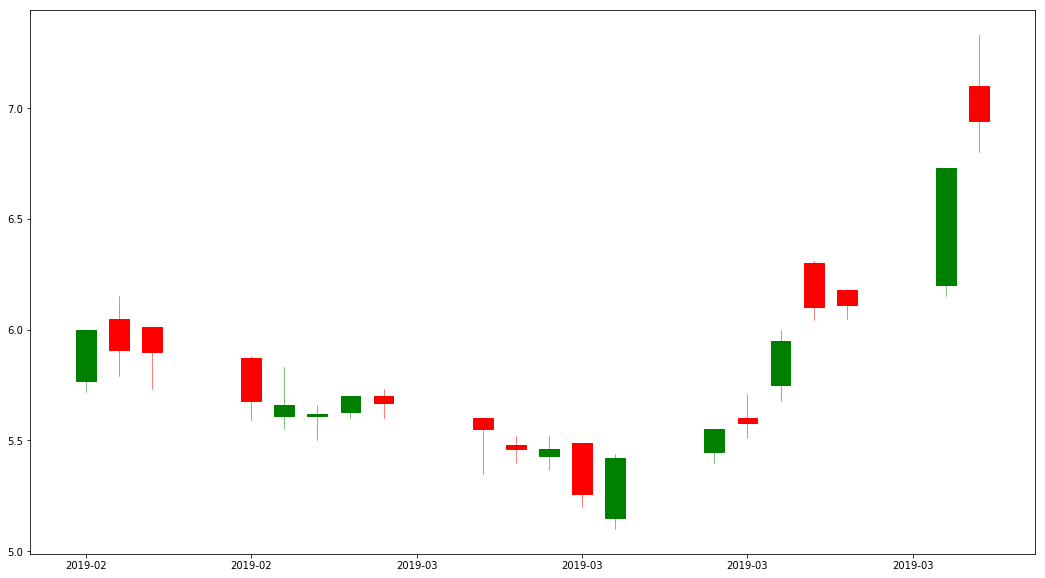

CRBP
['12.72% Change']


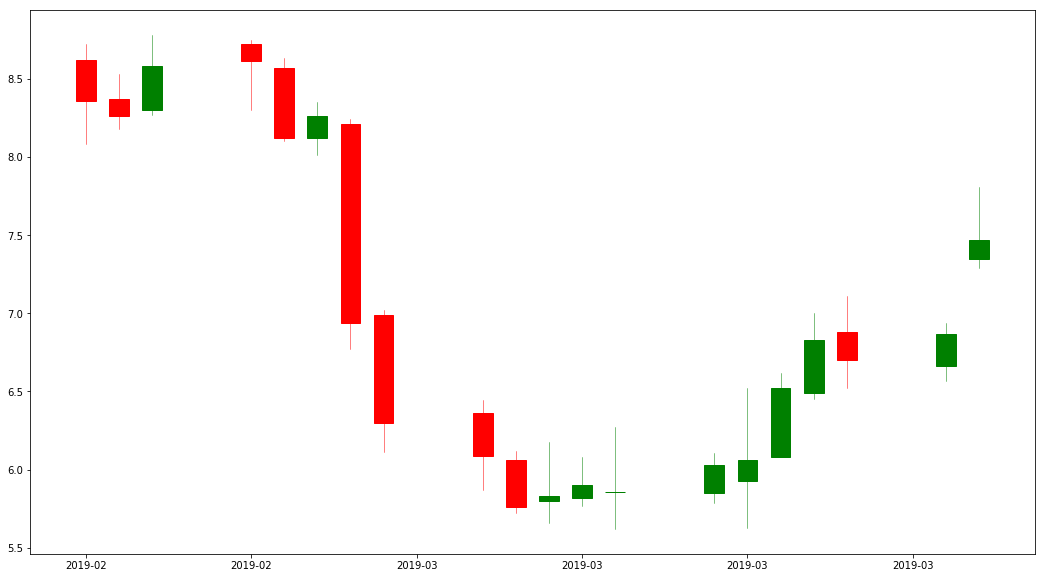

INSY
['11.64% Change']


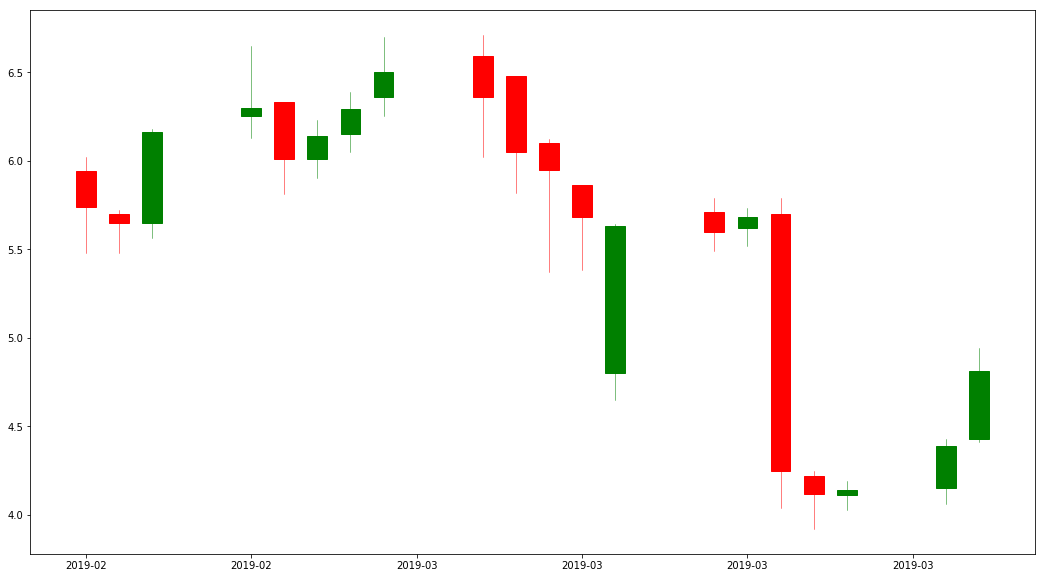

GLUU
['10.68% Change']


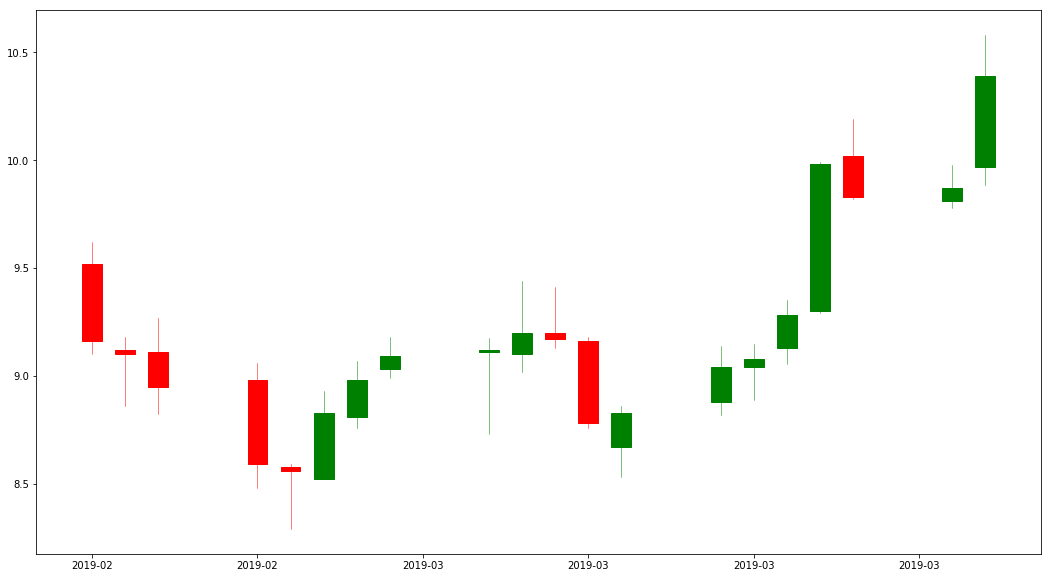

WFT
['10.19% Change']


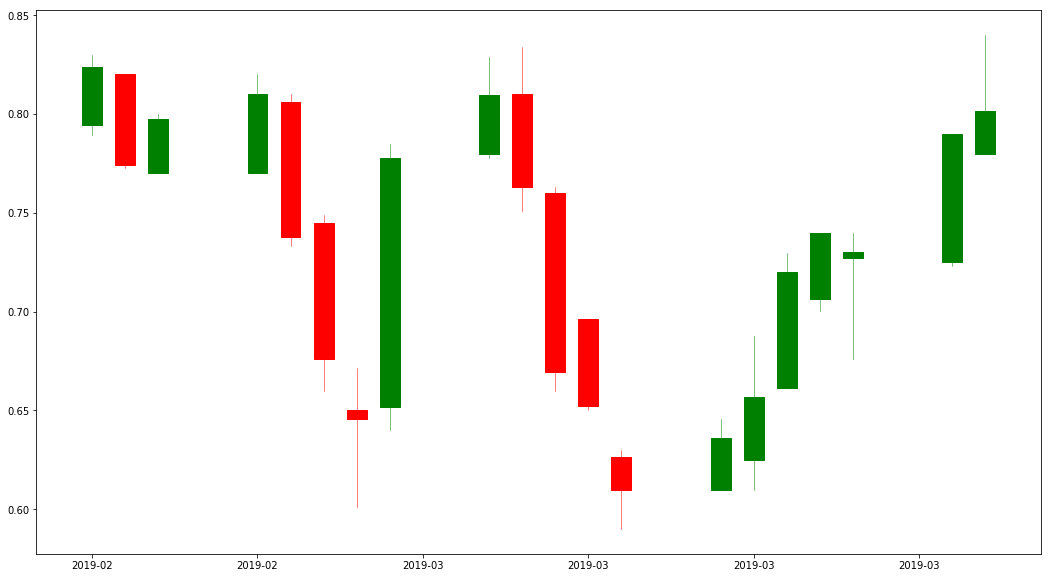

-----------------------------------------------------------------------------------------------------------


In [37]:
bullish_patterns(results)
print('-----------------------------------------------------------------------------------------------------------')
trenders(results)
print('-----------------------------------------------------------------------------------------------------------')
bearish_patterns(results)